# M07 - Caracterización y Agrupación de Usuarios en Redes Sociales mediante Análisis de Mensajes

Grupo 1:
- Juan Pablo Baudoin
- Fran Cassinese
- Martin Gruber
- Mariana Abayay

In [ ]:
Para ejecutar este notebook es requerido que los datos se encuentren en la carpeta data en la raiz del proyecto.
Tambien es necesario tener la carpeta lib con el archivo utils.py que contiene las funciones necesarias para la ejecucion de este notebook.


# Analisis exploratorio

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import emoji
import io
import chardet
from unidecode import unidecode
from pycountry import languages

from lib.utils import *

from pandarallel import pandarallel

pandarallel.initialize()
sns.set(rc={'figure.figsize':(10,6)})
pd.set_option('display.max_rows', 10) # cambiar el número de filas que se mostrarán usando display.max_rows.

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


## Lectura de datos

In [232]:
base_name = "dataset_diplodatos_corregido"
src_ds = f"data/{base_name}.csv"
df_ori = pd.read_csv(src_ds)
df_ori.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150519 entries, 0 to 150518
Data columns (total 7 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   id                150519 non-null  int64  
 1   commodity         119324 non-null  object 
 2   source_posted_at  150519 non-null  object 
 3   trade_type        141323 non-null  object 
 4   chat_id           150262 non-null  float64
 5   telegram_user_id  150262 non-null  float64
 6   message_text      150519 non-null  object 
dtypes: float64(2), int64(1), object(4)
memory usage: 8.0+ MB


In [233]:
# check if a file exists
import os
# Vamos a trabajar con una copia de los datos y generamos un archivo nuevo en el que adicionaremos 
# las columnas con información adicional.
work_file = f"data/{base_name}_enhanced.csv"
if not os.path.exists(work_file):
    print(f"Creating {work_file}")
    df.to_csv(work_file, index=False)
else:
    print(f"File {work_file} already exists. Loading it.")
    df = pd.read_csv(work_file)

df.info()


File data/dataset_diplodatos_corregido_enhanced.csv already exists. Loading it.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150519 entries, 0 to 150518
Data columns (total 7 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   id                150519 non-null  int64  
 1   commodity         119324 non-null  object 
 2   source_posted_at  150519 non-null  object 
 3   trade_type        141323 non-null  object 
 4   chat_id           150262 non-null  float64
 5   telegram_user_id  150262 non-null  float64
 6   message_text      150519 non-null  object 
dtypes: float64(2), int64(1), object(4)
memory usage: 8.0+ MB


## Revision de datos
En una primera revisión vamos a ver:
- Valores nulos
- Frecuencias de variables categoricas: commodity, trade_type, chat_id, telegram_user_id
- Analisis del campo message_text: mediante una inspeccion de datos muestral se ve que existen varios idiomas, que se tienen multiples encodings y se detecta el uso de emojis. Comportamiento esperado en mensajes de canales de chat en aplicaciones como telegram o whatsapp. Para el analisis del campo message_text, generaremos información adicional sobre el mismo:
  * Idioma
  * longitud caracteres
  * Numero de palabras
  * Cantidad de saltos de linea
  * Encodings



### Nulos

In [235]:
# get the percentage of missing values in the dataset
missing_values = df_ori.isnull().mean() * 100
# sort the columns by the percentage of missing values
missing_values = missing_values.sort_values(ascending=False)

filter_columns = missing_values > 0

print("############")
print("Columns with missing values")
for column, percentage in  missing_values[filter_columns].items():
    print(f"    {column}: {percentage:.2f}%")


filter_columns = missing_values == 0
print("############")
print("Columns with no missing values")
for column, percentage in  missing_values[filter_columns].items():
    print(f"    {column}")



############
Columns with missing values
    commodity: 20.72%
    trade_type: 6.11%
    chat_id: 0.17%
    telegram_user_id: 0.17%
############
Columns with no missing values
    id
    source_posted_at
    message_text


Es esperado que las columnas comodity, trade_type tengan valores nulos, pero en el caso de chat_id y telegram_user_id es un problema dado que nos interesa correlacionar usuarios y canales, por lo que esos registros deberían ser eliminados en la etapa de limpieza.

Las columnas completas son el id, la fecha y el mensaje, lo que esta ok. En el caso de la fecha, esta esta en formato de texto, por lo que hay que convertila de tipo date.

### Frecuencias simples

#### Top 10 de conteos

In [230]:
### Frecuencia de variables categóricas
print_top(df, 'commodity', "Currency", top=11)
print("--------")

print_top(df, 'chat_id', "Canal", top=11)
print("--------")

print_top(df, 'telegram_user_id', "Users", top=11)
print("--------")

print_top(df, 'trade_type', "Tipo Operación", top=11)
print("--------")


Top 11 Currency (commodity):
01 - N/A: 31195 	 (20.72%  - 20.72%) 	 (NaN)
02 - BTC: 5866 	 (3.9%  - 24.62%) 	 (W/NaN 4.92% - 4.92%)
03 - ETH: 3920 	 (2.6%  - 27.22%) 	 (W/NaN 3.29% - 8.21%)
04 - LTC: 2290 	 (1.52%  - 28.74%) 	 (W/NaN 1.92% - 10.13%)
05 - DYDX: 1832 	 (1.22%  - 29.96%) 	 (W/NaN 1.54% - 11.67%)
06 - BNB: 1636 	 (1.09%  - 31.05%) 	 (W/NaN 1.37% - 13.04%)
07 - AXS: 1565 	 (1.04%  - 32.09%) 	 (W/NaN 1.31% - 14.35%)
08 - TRX: 1531 	 (1.02%  - 33.11%) 	 (W/NaN 1.28% - 15.63%)
09 - MATIC: 1481 	 (0.98%  - 34.09%) 	 (W/NaN 1.24% - 16.87%)
10 - GALA: 1446 	 (0.96%  - 35.05%) 	 (W/NaN 1.21% - 18.08%)
11 - DOGE: 1361 	 (0.9%  - 35.95%) 	 (W/NaN 1.14% - 19.22%)
--------
Top 21 Canal (chat_id):
01 - 79.0: 29916 	 (19.88%  - 19.88%) 	 (W/NaN 19.91% - 19.91%)
02 - 101.0: 11278 	 (7.49%  - 27.37%) 	 (W/NaN 7.51% - 27.42%)
03 - 169.0: 9553 	 (6.35%  - 33.72%) 	 (W/NaN 6.36% - 33.78%)
04 - 173.0: 4433 	 (2.95%  - 36.67%) 	 (W/NaN 2.95% - 36.73%)
05 - 180.0: 3988 	 (2.65%  - 39.32%) 	 (W/

En la frecuencias simples de los datos categoricos tenemos:
- Comodity: como es esperado, las cryptomonedas más populares son las que tienen mayor participación, es importante notar que casi el 21% de los registros tienen valores nulos, por lo que la asociación monedas a mensajes tienen una gran cobertura. Por otro lado, el top 10 de las monedas cubre casi un 20% de los datos.
- Chat_id: se puede apreciar que hay un canal con muchos más mensajes que el resto 19.88%, los dos que siguen 7.49% y 6.35% y despues menos de 3% y 2%. El top 10 de canales cubre el 49% de los datos.
- telegram_user_id: Es interesa notar que el top 10 de los usuarios tiene exactamente las mismas cantidades de mensajes que los chats, esto significa que en esos canales solo escribe un usuario.

In [236]:
# count the number of chat_ids
chat_ids = df['chat_id'].nunique()
print(f"Number of chat_ids: {chat_ids}")

# count the number of users
users = df['telegram_user_id'].nunique()
print(f"Number of users: {users}")

print(f"El {10/chat_ids:.2%} de los canales concentra el 49.13% de los mensajes")
print(f"El {10/users:.2%} de los usuarios concentra el 49.13% de los mensajes")


Number of chat_ids: 491
Number of users: 3892
El 2.04% de los canales concentra el 49.13% de los mensajes
El 0.26% de los usuarios concentra el 49.13% de los mensajes


#### Chats y Usuarios

In [237]:
# Canales con un solo usuario
chat_users = df.groupby('chat_id')['telegram_user_id'].nunique()
chat_users = chat_users.sort_values(ascending=False)
single_user_chats = chat_users[chat_users == 1]
print(f"Number of chats with a single user: {single_user_chats.count()}")
print(f"Number of chats with a single user: {single_user_chats.count()/chat_ids:.2%}")


# Usuarios con un solo canal
user_chats = df.groupby('telegram_user_id')['chat_id'].nunique()
user_chats = user_chats.sort_values(ascending=False)
single_chat_users = user_chats[user_chats == 1]
print(f"Number of users with a single chat: {single_chat_users.count()}")
print(f"Number of users with a single chat: {single_chat_users.count()/users:.2%}")


# Distribucion de numero de mensajes por canal


Number of chats with a single user: 405
Number of chats with a single user: 82.48%
Number of users with a single chat: 3857
Number of users with a single chat: 99.10%


Por lo que se ve, en la mayoría de los canales escribe un solo usuario, menos del 20% de los canales tiene más de un usuario.

En cuanto a los usuarios, solo un 0.8% escribe en más de un canal.

In [8]:
# Canales con más de un usuario sort by number of users
multi_user_chats = chat_users[chat_users > 1]

print(f"Number of chats with more than one user: {multi_user_chats.count()}")
print(f"Number of chats with more than one user: {multi_user_chats.count()/chat_ids:.2%}")
print(multi_user_chats)

print("--------")

# Usuarios con más de un canal
multi_chat_users = user_chats[user_chats > 1]
print(f"Number of users with more than one chat: {multi_chat_users.count()}")
print(f"Number of users with more than one chat: {multi_chat_users.count()/users:.2%}")
print(multi_chat_users)




Number of chats with more than one user: 86
Number of chats with more than one user: 17.52%
chat_id
3455.0    519
3389.0    510
3396.0    372
1.0       275
2964.0    214
         ... 
3464.0      2
3454.0      2
78.0        2
3457.0      2
3636.0      2
Name: telegram_user_id, Length: 86, dtype: int64
--------
Number of users with more than one chat: 35
Number of users with more than one chat: 0.90%
telegram_user_id
5380.0       4
2640755.0    2
2680874.0    2
2696977.0    2
2686427.0    2
            ..
2626020.0    2
610825.0     2
2634301.0    2
2989908.0    2
2978476.0    2
Name: chat_id, Length: 35, dtype: int64


Este analisis indica que si bien es posible la publicación cruzada en canales, no es algo tan comun usando el mismo usuario. En su mayoría los usuarios que publican en más de un canal solo lo hacen en dos y tenemos un solo caso que lo hace en 4. 

En cuanto a canales que tienen más de un usario no son muchos 86 en total y coresponde a 17.52% del total de chats.


### Limpieza de datos y enriquecimiento simple

Para continuar con el analisis exploratorio, como indicamos antes, necesitamo realizar una limpieza y enriequecimiento de datos inicial. Vamos a proceder a adicionar las siguientes columnas:
- date_source_posted_at: transformación del campo date_source a formato fecha
- message_text_clean: aplicar las siguentes transformaciones al message_text
    - Clean_lbr: consolidar saltos de linea repetidos en uno solo.
    - Clean emojis: Remover los emojis
- message_encoding: identificar el encoding de message_text_clean
- message_text_clean_utf8: convertir message_text_clean a encoding utf8, cuando no sea utf8 o ascii.
- message_length: Contar los caracteres de linea de message_text_clean_utf8
- message_words: Contar las palabras en el campo message_text_clean_utf8
- message_lbr: Contar los salos de linea de message_text_clean_utf8
- message_encoding2: identificar el encoding de message_text_clean_utf8
- language: identificar el idioma de message_text_clean_utf8


In [238]:
force_process = False

if 'message_length' not in df.columns or force_process :

    df['date_source_posted_at'] = pd.to_datetime(df['source_posted_at'])

    # sort the data by chat_id and date_source_posted_at
    df = df.sort_values(by=['chat_id', 'date_source_posted_at'])

    ### Limpieza sobre el encoding original de los mensajes ###
    ###########################################################
    # Trim and remove multiple line breaks
    df['message_text_clean'] = df['message_text'].apply(clean_lbr)

    # Eliminar emojis y añadir columna message_no_emoji
    df['message_text_clean'] = df['message_text_clean'].apply(remove_emojis).str.strip().str.lower()

    # # Detect the encoding of messages in the field message_text_clean of type string\
    df['message_encoding'] = df['message_text_clean'].apply(lambda x: chardet.detect(x.encode())['encoding'])


    ### Limpieza sobre el encoding utf8 ###
    #######################################
    df['message_text_clean_utf8'] = df['message_text_clean']

    # # convert the all the messages to utf-8 where the encoding is different form utf-8
    


    flt = df['message_encoding'] != 'utf-8'
    df.loc[flt, 'message_text_clean_utf8'] = df[flt]['message_text_clean'].apply(lambda x: unidecode(x))

    df['message_encoding2'] = df['message_text_clean_utf8'].apply(lambda x: chardet.detect(x.encode())['encoding'])

    # Añadir columna con la longitud del mensaje sin emojis
    df['message_length'] = df['message_text_clean_utf8'].str.len()

    # Añadir columna con el número de palabras
    df['message_words'] = df['message_text_clean_utf8'].apply(lambda x: len(x.split()))

    # Añadir columna con el número de saltos de línea
    df['message_lbr'] = df['message_text_clean_utf8'].apply(count_line_breaks)
    df.to_csv(work_file, index=False)


In [250]:
# identificacion de idioma con librería langdetect
force_lang_detect = False
if 'language' not in df.columns or force_lang_detect:
    df['language'] = df['message_text_clean_utf8'].parallel_apply(detect_language)
    df.to_csv(src_ds, index=False)

No features in text. https://www.theblock.co/post/162913/ethereums-final-proof-of-stake-test-merge-is-live-on-goerli?utm_source=twitter&utm_medium=social
No features in text. https://thehiddenwiki.com/new-long-v3-onion-services-version-3-hidden-service-links-on-the-hidden-wiki/
No features in text. https://www.tradingview.com/chart/btcusdt/wq95qni6-buylong-1h-4h-green-area-signal-buy-bo-mid-band/wq95qni6
No features in text. https://www.tradingview.com/chart/btcusdt/accixc3k-buylong-4h-green-area-oversold-rebound/accixc3k
No features in text. https://www.tradingview.com/chart/btcusdt/beaflobw-buylong1h-green-area-signal-buy-bo-mid-band/beaflobw
No features in text. https://www.tradingview.com/chart/ethusdt/7ppqlkph-buylong-1h-green-area-signal-buy-bo-mid-band/7ppqlkph
No features in text. https://www.tradingview.com/chart/ethusdt/7f3mdpx6-buy-eth-ethusdt-buylong-timeframe-4h-sadis/7f3mdpx6
No features in text. https://www.tradingview.com/chart/btcusdt/iwnufnrm-buy-btc-btcusdt-buylong-t

In [240]:
from langid.langid import LanguageIdentifier, model

# Identificación de idioma con librería langid
identifier = LanguageIdentifier.from_modelstring(model, norm_probs=True)
def detect_language2(text):
    try:
        return list(identifier.classify(text))
    except Exception as e:
        print(e, text)
        return "Error langdetect"


In [245]:
force_lang_detect2 = False
if 'language2' not in df.columns or force_lang_detect2:
    df['lang_tmp'] = df['message_text_clean_utf8'].parallel_apply(detect_language2)
    df[['language2', 'language2_score']] = pd.DataFrame(df['lang_tmp'].tolist(), index=df.index)
    df.drop(columns=['lang_tmp'], inplace=True)
    df.to_csv(src_ds, index=False)


In [246]:
# language3 is equal to language2 if the score is greater than 0.5
df['language3'] = df['language2']
df.loc[df['language2_score'] < 0.5, 'language3'] = '??'


NOTA: la detección de idioma se ve afectada por el encoding y la presencia de los emojis, es por eso que se realiza sobre el campo message_text_clean_utf8.

#### Revision de nuevos datos

##### Encoding

In [242]:
# count the number of messages per encoding
print(df['message_encoding'].value_counts())
print("--------")
print(df['message_encoding2'].value_counts())

message_encoding
ascii           131331
utf-8             8273
Windows-1254      5666
Windows-1252      3745
ISO-8859-1        1125
                 ...  
Johab                5
EUC-JP               4
windows-1253         1
TIS-620              1
GB2312               1
Name: count, Length: 12, dtype: int64
--------
message_encoding2
ascii    142246
utf-8      8273
Name: count, dtype: int64


In [261]:
# Original text in Windows-1252 encoding
# windows_1252_text = b'target 40$. ch\xe1\xbb\x91t all'

src_text = "target 40$. chốt all"
# Decode src_text to a Unicode string
unicode_text = src_text.encode('utf-8').decode('utf-8')


unicode_text = windows_1252_text.decode('windows-1252')


# Decode the Windows-1252 encoded text to a Unicode string
unicode_text = windows_1252_text.decode('windows-1252')

# Encode the Unicode string to UTF-8
utf8_text = unicode_text.encode('utf-8')


print(windows_1252_text)
print(unicode_text)
print(utf8_text)

print(type(utf8_text))

# Decode the UTF-8 encoded text to a Unicode string
unicode_text2 = utf8_text.decode('utf-8')
print(unicode_text2)

# detect the encoding of unicode_text2
print(chardet.detect(unicode_text2.encode()))


b'target 40$. ch\xe1\xbb\x91t all'
target 40$. chá»‘t all
b'target 40$. ch\xc3\xa1\xc2\xbb\xe2\x80\x98t all'
<class 'bytes'>
target 40$. chá»‘t all
{'encoding': 'utf-8', 'confidence': 0.87625, 'language': ''}


In [252]:
# from df filter rows where message_encoding is not utf-8 
# and message_text_clean is not equal to message message_text_clean_utf8
filter_rows = (df['message_encoding'] != 'utf-8') & (df['message_text_clean'] != df['message_text_clean_utf8'])
print(f"Number of rows with message_encoding different from utf-8 and")
print(f"message_text_clean different from message_text_clean_utf8: {filter_rows.sum()}")
print("--------")


for index, row in df[filter_rows][['message_text_clean', 'message_text_clean_utf8', 'message_encoding', 'message_encoding2']].head(3).iterrows():
    print(row['message_encoding'])
    print(row['message_text_clean'])
    print("   -> ")
    print(row['message_encoding2'])
    print(row['message_text_clean_utf8'])
    print("--------")



Number of rows with message_encoding different from utf-8 and
message_text_clean different from message_text_clean_utf8: 10915
--------
Windows-1252
target 40$. chốt all
   -> 
ascii
target 40$. chot all
--------
MacRoman
làm 1 cua long target 80k ko :))))
   -> 
ascii
lam 1 cua long target 80k ko :))))
--------
ISO-8859-9
phá 27x target 30$
   -> 
ascii
pha 27x target 30$
--------


Ahora se tienen datos con ascii y utf8.
Los cambios de encoding afectan a palabras con acentos de distintos tipos, comillas simples, carateres no imprimibles y caracteres de monedas.
Como puede afectar el cambio de encoding a la detección de idiomas?
Conviene realizar la detección previo a el cambio de encoding?
Se puede hacer reemplazo de caracteres confundibles en otro encoding a utf-8? 
Los paso a utf8 o a ascii?

##### Idioma

In [153]:
# count the number of messages per language and their percentage, acumulated percentage and sorted by count
language_fld = 'language3'

language_counts = df[language_fld].value_counts()
language_counts = language_counts.reset_index()
language_counts.columns = [language_fld, 'count']
language_counts['percentage'] = language_counts['count'] / language_counts['count'].sum()
language_counts['cum_percentage'] = language_counts['percentage'].cumsum()
language_counts = language_counts.sort_values(by='count', ascending=False)

# print the language name from their code
language_counts['language_name'] = language_counts[language_fld].apply(lambda x: emoji.demojize(x))


# print the top 5 languages with the highest number of messages and their percentages and acumulated percentages formatted
total_langs = language_counts.shape[0]
print(f"Total number of languages: {total_langs}")
top_langs = 15
for index, row in language_counts.head(top_langs).iterrows():
    lang_code = row[language_fld]
    if lang_code == '??':
        language_name = 'Unknown'
    else:
        language_name = languages.get(alpha_2=lang_code).name
    print(f"{language_name:<9}({lang_code}): {row['count']: 7}({round(row['percentage'],4):6.2%}, {round(row['cum_percentage'],4):.2%})")


Total number of languages: 71
English  (en):  119062(79.10%, 79.10%)
unknown  (??):   21113(14.03%, 93.13%)
Arabic   (ar):    2011( 1.34%, 94.46%)
French   (fr):    1516( 1.01%, 95.47%)
Korean   (ko):    1108( 0.74%, 96.21%)
Polish   (pl):     928( 0.62%, 96.82%)
Persian  (fa):     857( 0.57%, 97.39%)
Dutch    (nl):     718( 0.48%, 97.87%)
Spanish  (es):     662( 0.44%, 98.31%)
Danish   (da):     434( 0.29%, 98.60%)
Breton   (br):     208( 0.14%, 98.74%)
German   (de):     202( 0.13%, 98.87%)
Slovak   (sk):     196( 0.13%, 99.00%)
Indonesian(id):     149( 0.10%, 99.10%)
Vietnamese(vi):     132( 0.09%, 99.19%)


In [247]:
# Lenguajes por canal
# Cuantos lenguajes hay por canal
chat_lang = df.groupby('chat_id')[language_fld].nunique()
chat_lang = chat_lang.sort_values(ascending=False)
print(f"Number of languages by chat_id")
print(chat_lang)

# Cuantos lenguajes hay por usuario
user_lang = df.groupby('telegram_user_id')[language_fld].nunique()
user_lang = user_lang.sort_values(ascending=False)
print(f"Number of languages by user_id")
print(user_lang)



Number of languages by chat_id
chat_id
8.0       20
3508.0    18
1.0       17
81.0      16
208.0     15
          ..
2216.0     1
2247.0     1
2248.0     1
2257.0     1
3666.0     1
Name: language3, Length: 491, dtype: int64
Number of languages by user_id
telegram_user_id
848342.0     20
977908.0     16
2627215.0    15
977890.0     15
848300.0     14
             ..
2680663.0     1
2680695.0     1
2680720.0     1
288346.0      1
2699163.0     1
Name: language3, Length: 3892, dtype: int64


In [248]:
# Seleciona los mensajes del usuario con el id XXX y lenguaje esta en la lista 'en', 'es'
user_id = 848342.0
user_messages = df[(df['telegram_user_id'] == user_id) & (~df[language_fld].isin(['en', 'Unknown']))]
print(f"Number of messages from user {user_id}: {user_messages.shape[0]}")
print(f"Number of messages from user {user_id}: {user_messages.shape[0]/df.shape[0]:.2%}")

user_messages

Number of messages from user 848342.0: 818
Number of messages from user 848342.0: 0.54%


,id,commodity,source_posted_at,trade_type,chat_id,telegram_user_id,message_text,date_source_posted_at,message_text_clean,message_encoding,message_text_clean_utf8,message_encoding2,message_length,message_words,message_lbr,language2,language2_score,language3
55361,109626,FLM,2022-01-02 00:17:53+00,sell,8.0,848342.0,1 target done FLM Reached 0.3740 profit 21%🤑🚀🚀...,2022-01-02 00:17:53+00:00,1 target done flm reached 0.3740 profit 21%,ascii,1 target done flm reached 0.3740 profit 21%,ascii,43,8,0,fr,0.453621,??
12944,114243,ZRX,2022-01-02 08:43:58+00,sell,8.0,848342.0,#ZRX/USDT\nFirst Target Achieved✅✅✅📈,2022-01-02 08:43:58+00:00,#zrx/usdt\nfirst target achieved,ascii,#zrx/usdt\nfirst target achieved,ascii,31,4,1,en,0.204383,??
54257,110158,ALGO,2022-01-05 07:46:33+00,buy,8.0,848342.0,📈 VIP SIGNAL: 0279\n\n💎$ALGO/USDT Long\n\n✅Ris...,2022-01-05 07:46:33+00:00,vip signal: 0279\n$algo/usdt long\nrisk entry ...,ascii,vip signal: 0279\n$algo/usdt long\nrisk entry ...,ascii,184,41,14,no,0.564162,no
57193,110198,FTM,2022-01-06 14:14:51+00,sell,8.0,848342.0,#FTM/USDT\nFirst target achieved🚀🚀🔥📈\n165% pro...,2022-01-06 14:14:51+00:00,#ftm/usdt\nfirst target achieved\n165% profit,ascii,#ftm/usdt\nfirst target achieved\n165% profit,ascii,43,6,2,en,0.169462,??
132971,113977,CLV,2022-01-07 20:29:09+00,buy,8.0,848342.0,💎Long-Term Dip Buying Update💎\n\n\nCoins To Bu...,2022-01-07 20:29:09+00:00,long-term dip buying update\ncoins to buy now ...,utf-8,long-term dip buying update\ncoins to buy now ...,utf-8,1365,216,22,he,1.000000,he
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28701,172057,SOL,2022-11-02 06:07:49+00,sell,8.0,848342.0,📊 #SOL [ Trade Update ]\n\n💰 Profit : 27% 🔥...,2022-11-02 06:07:49+00:00,#sol [ trade update ]\n profit : 27% \n tar...,ascii,#sol [ trade update ]\n profit : 27% \n tar...,ascii,54,11,2,en,0.169462,??
28702,172058,SRM,2022-11-02 06:07:49+00,sell,8.0,848342.0,📊 #SRM [ Trade Update ]\n\n💰 Profit : 23% 🔥...,2022-11-02 06:07:49+00:00,#srm [ trade update ]\n profit : 23% \n tar...,ascii,#srm [ trade update ]\n profit : 23% \n tar...,ascii,54,11,2,en,0.169462,??
9510,195069,NEAR,2022-11-22 20:58:00+00,buy,8.0,848342.0,………🎅………\n\n🎖️#NEAR/USDT\n\n⏫️Signal type: LONG...,2022-11-22 20:58:00+00:00,………………\n#near/usdt\nsignal type: long\n levera...,utf-8,………………\n#near/usdt\nsignal type: long\n levera...,utf-8,169,29,12,bn,0.980502,bn
23030,206805,AXS,2022-12-06 04:29:13+00,buy,8.0,848342.0,🟥 SHORT\n\n#AXS/USDT \n\n✅ Entry zone 8.452 - ...,2022-12-06 04:29:13+00:00,short\n#axs/usdt\n entry zone 8.452 - 8.543\n ...,ascii,short\n#axs/usdt\n entry zone 8.452 - 8.543\n ...,ascii,126,22,5,pl,0.890666,pl


In [170]:
# filter the rows with language ar
filter_rows = df[language_fld] == 'ar'
print(f"Number of rows with language ar: {filter_rows.sum()}")
print("--------")
print("Columns with language ar")
df[filter_rows][['message_text_clean', 'message_text_clean_utf8', 'language3']]
for index, row in df[filter_rows][['message_text_clean', 'message_text_clean_utf8', 'language3']].head(3).iterrows():
    print(row['message_text_clean'])
    print("   -> ")
    print(row['message_text_clean_utf8'])
    print("--------")


Number of rows with language ar: 2011
--------
Columns with language ar
باقي 3 دقائق على البامب الرسالة القادمة اسم العملة  
3 minutes left on the pump, the next message is the name of the currency
   -> 
باقي 3 دقائق على البامب الرسالة القادمة اسم العملة  
3 minutes left on the pump, the next message is the name of the currency
--------
سيكون مضخة البامب غدا كبيرة بعد الكروب الكبير للفي اي بي واذا حقق البامب كما ينبغي راح نفتح مجال الاستثمار في البامبات غدا 
tomorrow the pump will be big after the great trouble of the vip, and if the pump is achieved as it should, we will open the field of investment in the pumps tomorrow
   -> 
سيكون مضخة البامب غدا كبيرة بعد الكروب الكبير للفي اي بي واذا حقق البامب كما ينبغي راح نفتح مجال الاستثمار في البامبات غدا 
tomorrow the pump will be big after the great trouble of the vip, and if the pump is achieved as it should, we will open the field of investment in the pumps tomorrow
--------
باقي 15 دقيقة على البامب
15 minutes left on the pump
   -> 
با

La identificación de lenguaje tiene falsos positivos, a pesar de eso es notorio y evidente que el lenguaje predominante es el ingles.

Creemos que el analisis del idioma va a ayudar en el analisis, sin embargo, la identificación correcta del idioma requiere más trabajo respecto a:
- mensajes con más de un idioma
- mensajes cortos
- mensajes con pocas palabras en un idioma y codificaciones
- identificación de codificaciones que no tienen idiomas

#### Mensajes duplicados

In [318]:
# Find duplicated messages 
duplicated_messages = df[df.duplicated(subset=['message_text_clean_utf8'], keep=False)]
duplicated_messages = duplicated_messages.sort_values(by=['message_text_clean_utf8'])
print(f"Number of duplicated messages: {duplicated_messages.shape[0]}")
# percentage of duplicated messages
print(f"Percentage of duplicated messages: {duplicated_messages.shape[0]/df.shape[0]:.2%}")
print("--------")


Number of duplicated messages: 52110
Percentage of duplicated messages: 34.62%
--------


In [316]:
duplicated_messages[['message_text_clean_utf8', 'chat_id', 'telegram_user_id']]

,message_text_clean_utf8,chat_id,telegram_user_id
102300,SCALPING 300 ]\ns*cdega@ldegp*i... 1inchusdt ...,79.0,977825.0
102225,SCALPING 300 ]\ns*cdega@ldegp*i... 1inchusdt ...,79.0,977825.0
81181,SCALPING 300 ]\ns*cdega@ldegp*i... 1inchusdt ...,79.0,977825.0
75472,SCALPING 300 ]\ns*cdega@ldegp*i... 1inchusdt ...,79.0,977825.0
54855,SCALPING 300 ]\ns*cdega@ldegp*i... 1inchusdt ...,79.0,977825.0
...,...,...,...
147568,【get rich quickly】 chess and cards entertainm...,3578.0,3178785.0
147552,【get rich quickly】 chess and cards entertainm...,3578.0,3178785.0
147627,【get rich quickly】 chess and cards entertainm...,3578.0,3178785.0
148530,【get rich quickly】 chess and cards entertainm...,3578.0,3178785.0


In [319]:
duplicated_df = duplicated_messages.groupby('message_text_clean_utf8').agg({
    'id': lambda x: list(x),
    'telegram_user_id': lambda x: set(x),
    'chat_id': lambda x: set(x),
    'message_text_clean_utf8': 'size'
}).rename(columns={'message_text_clean_utf8': 'count'}).reset_index()

# Rename columns as required
duplicated_df = duplicated_df.rename(columns={'id': 'ids', 'telegram_user_id': 'users', 'chat_id': 'chats'})

duplicated_df['num_users'] = duplicated_df['users'].apply(len)
duplicated_df['num_chats'] = duplicated_df['chats'].apply(len)


# filter duplicated messages with more than one user or chat
filter_rows = (duplicated_df['num_users'] > 1) | (duplicated_df['num_chats'] > 1)
print(f"Number of duplicated messages with more than one user or chat: {filter_rows.sum()}")
# percentage of duplicated messages with more than one user or chat
print(f"Percentage of duplicated messages with more than one user or chat: {filter_rows.sum()/duplicated_df.shape[0]:.2%}")

print("--------")
print("Duplicated messages with more than one user or chat")
duplicated_df[filter_rows].sort_values(by='count', ascending=False) 


Number of duplicated messages with more than one user or chat: 6368
Percentage of duplicated messages with more than one user or chat: 38.69%
--------
Duplicated messages with more than one user or chat


,message_text_clean_utf8,ids,users,chats,count,num_users,num_chats
14478,ok,"[748778, 833562, 751709, 751728, 748528, 75051...","{2859521.0, 2972162.0, 3000834.0, 2976258.0, 2...","{2835.0, 2964.0, 3604.0, 3099.0, 3376.0, 3386....",234,202,24
5689,2 minutes left until our pump \nthe next messa...,"[167547, 164298, 16010, 165788, 64915, 168399,...","{848448.0, 977862.0, 977904.0, 977907.0, 20313...","{136.0, 13.0, 142.0, 120.0, 2141.0}",207,5,5
6094,5 minutes left until our pump \nbe prepared fo...,"[8534, 64797, 65140, 11707, 64550, 65262, 1668...","{977904.0, 977907.0, 848448.0, 977862.0}","{120.0, 13.0, 136.0, 142.0}",191,4,4
5452,10 minutes left until our pump,"[164493, 168008, 64864, 165988, 167073, 167595...","{848448.0, 977958.0, 977904.0, 977907.0, 97797...","{136.0, 233.0, 108.0, 13.0, 120.0, 2141.0, 94.0}",174,7,7
5284,1 hour left until our pump,"[504022, 166011, 167935, 12516, 64647, 167583,...","{848448.0, 977958.0, 977904.0, 977907.0, 20313...","{136.0, 233.0, 13.0, 120.0, 2141.0, 94.0, 31.0}",161,7,7
...,...,...,...,...,...,...,...
9201,binance futures\n#skl/usdt take-profit target ...,"[200447, 200446]","{977827.0, 977901.0}","{210.0, 173.0}",2,2,2
9202,binance futures\n#skl/usdt take-profit target ...,"[212069, 212070]","{977827.0, 977846.0}","{210.0, 181.0}",2,2,2
9203,binance futures\n#skl/usdt take-profit target ...,"[200514, 200515]","{977827.0, 977901.0}","{210.0, 173.0}",2,2,2
9206,binance futures\n#skl/usdt take-profit target ...,"[201398, 201399]","{977827.0, 977901.0}","{210.0, 173.0}",2,2,2


Hemos comprobado que un 34.62% de los mensajes tienen duplicados, de estos mensajes el 38.69% son mensajes posteado por diferenctes usuarios o en diferentes canales y el resto por el mismo usuario y en el mismo canal.

En cuanto al contenido de los mensajes, hay mensajes muy genericos como 'ok' o '10 minutes left until our pump', y otros como 'binance futures\n#skl/usdt take-profit target ...' que indican monedas, exchange y acciones.

Considerando que este analisis simple, solo considerón mensajes identicos, cuando realicemos un analisis a nivel de patrones y contenido, seguro que las correlaciones y coincidencias serán mayores.

##### Longitudes de texto
En esta revisión trabajaremos con las columnas de logitudes de texto adionadas:
- message_length
- message_lbr
- message_words

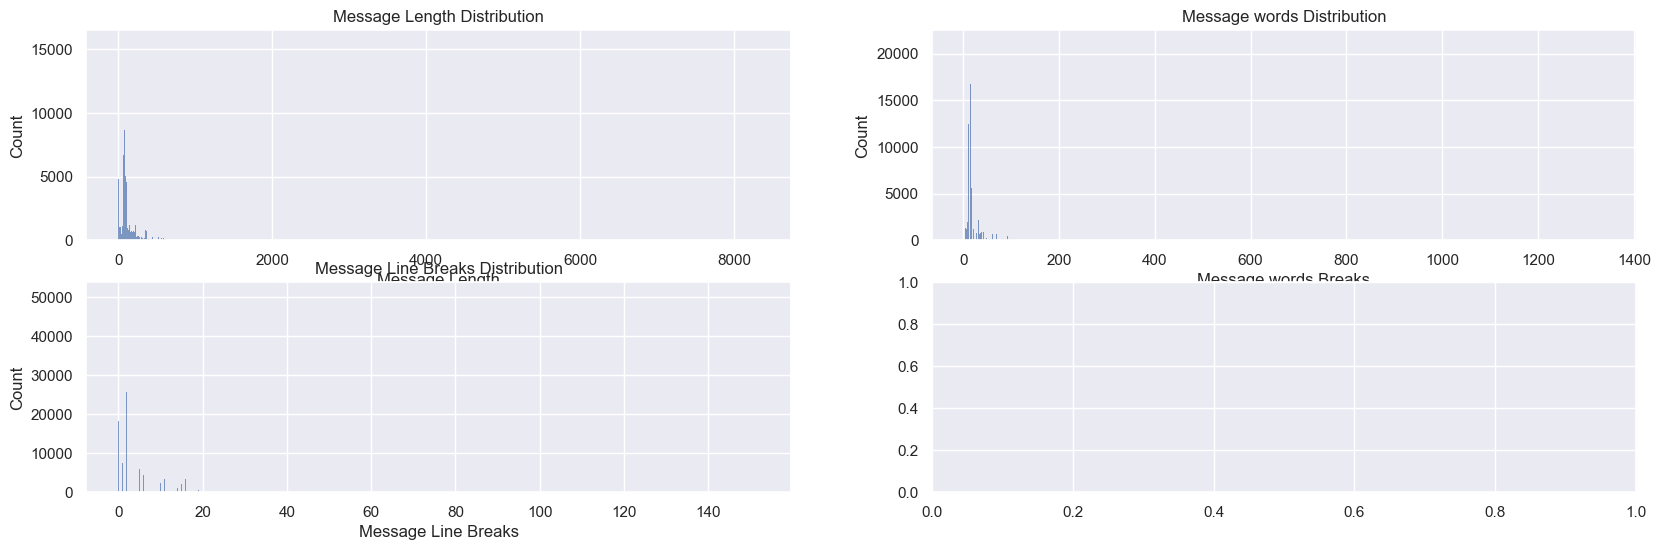

In [181]:
# Generate a distribution plots for message_length and message_lbr
# the plots should one next to the other
# we need to be able to set the size of the plots
# the plots should have a title
# the plots should have labels for the x and y axis

fig, axs = plt.subplots(2, 2, figsize=(20, 6))
sns.histplot(data=df, x='message_length', ax=axs[0,0])
axs[0,0].set_title('Message Length Distribution')
axs[0,0].set_xlabel('Message Length')
axs[0,0].set_ylabel('Count')
# axs[0,0].set_yscale('log')

sns.histplot(data=df, x='message_words', ax=axs[0,1])
axs[0,1].set_title('Message words Distribution')
axs[0,1].set_xlabel('Message words Breaks')
axs[0,1].set_ylabel('Count')
# axs[0,1].set_yscale('log')

sns.histplot(data=df, x='message_lbr', ax=axs[1,0])
axs[1,0].set_title('Message Line Breaks Distribution')
axs[1,0].set_xlabel('Message Line Breaks')
axs[1,0].set_ylabel('Count')
# axs[1,0].set_yscale('log')

plt.show()

Como es esperable, hay una alta concentración de mensajes cortos, pocas palabras y saltos de linea.
Revisaremos más de cerca los datos con valores abitrarios para hacer un rango más acotado.

In [182]:
df[['message_length', 'message_words', 'message_lbr']].describe()

,message_length,message_words,message_lbr
count,150519.000000,150519.000000,150519.000000
mean,156.178144,25.072330,4.724739
std,219.701556,37.131854,4.982413
min,1.000000,1.000000,0.000000
25%,80.000000,11.000000,2.000000
50%,96.000000,15.000000,3.000000
75%,172.000000,27.000000,5.000000
max,8322.000000,1338.000000,152.000000


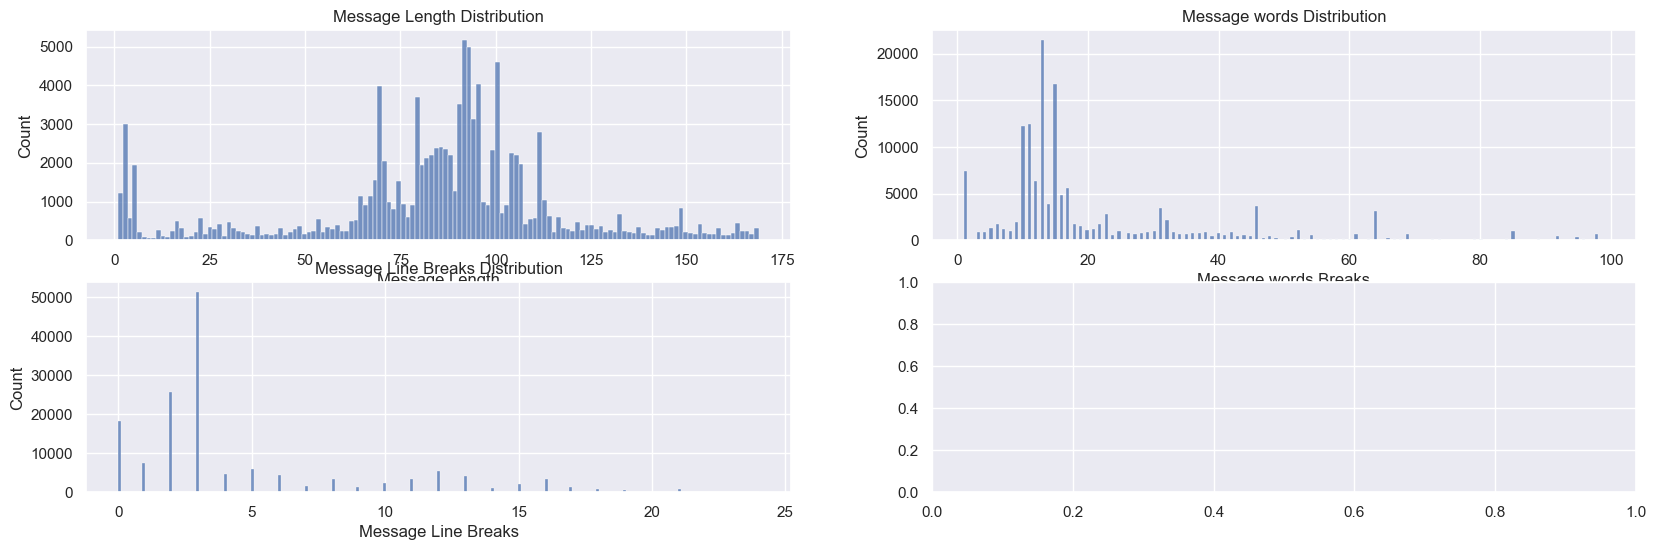

In [188]:


fig, axs = plt.subplots(2, 2, figsize=(20, 6))

flt_ml = df['message_length'] < 170
sns.histplot(data=df[flt_ml], x='message_length', ax=axs[0,0])
axs[0,0].set_title('Message Length Distribution')
axs[0,0].set_xlabel('Message Length')
axs[0,0].set_ylabel('Count')
# axs[0,0].set_yscale('log')

flt_mw = df['message_words'] < 100
sns.histplot(data=df[flt_mw], x='message_words', ax=axs[0,1])
axs[0,1].set_title('Message words Distribution')
axs[0,1].set_xlabel('Message words Breaks')
axs[0,1].set_ylabel('Count')
# axs[0,1].set_yscale('log')

flt_mbr = df['message_lbr'] < 25
sns.histplot(data=df[flt_mbr], x='message_lbr', ax=axs[1,0])
axs[1,0].set_title('Message Line Breaks Distribution')
axs[1,0].set_xlabel('Message Line Breaks')
axs[1,0].set_ylabel('Count')
# axs[1,0].set_yscale('log')

plt.show()

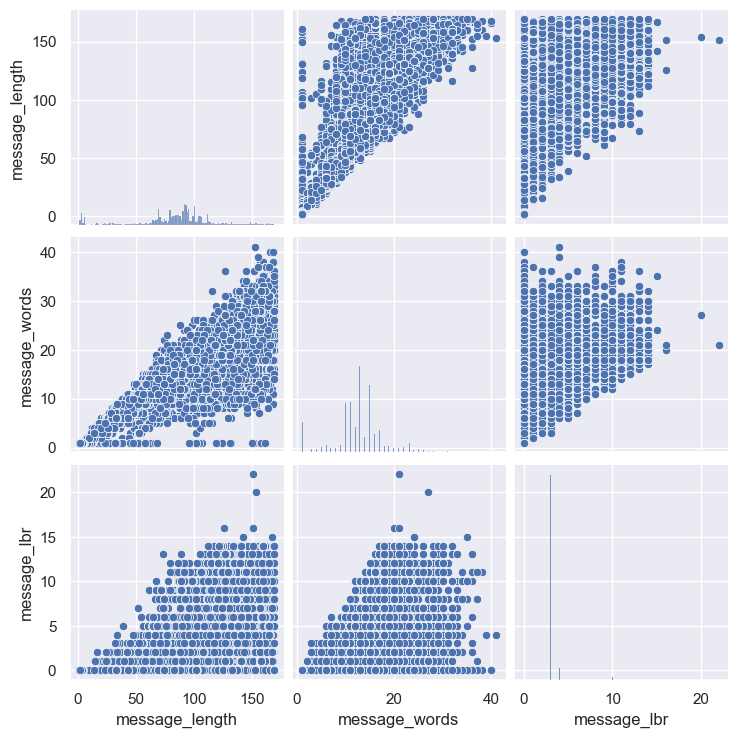

In [275]:
# pairplot of message_length, message_words and message_lbr
flt = flt_ml & flt_mw & flt_mbr
sns.pairplot(data=df[flt][['message_length', 'message_words', 'message_lbr']])
# hihglight more dense areas with color
plt.show()


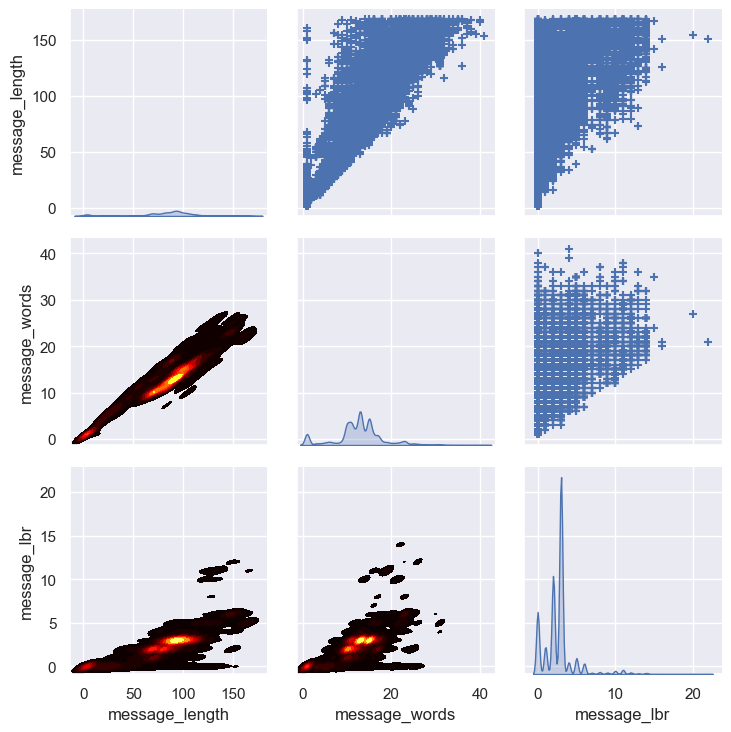

In [194]:
g = sns.PairGrid(df[flt][['message_length', 'message_words', 'message_lbr']])
g = g.map_upper(plt.scatter, marker='+')
g = g.map_lower(sns.kdeplot, cmap="hot",fill=True)
g = g.map_diag(sns.kdeplot, fill=True)


Al ver los plots cruzado con el mapa de calor, es claro que hay dos grupo de mensajes mayoritarios definidos por el numero de caracteres/palabras y los saltos de linea. Tambien se aprecia una relacion entre la longitud del mensaje y el numero de palabras, lo que es esperable.
Grupo 1 - mayor:
  - message_length: [50, 130]
  - message_lbr:    [2, 4]
  - message_words:  [9, 17]

Grupo 2 - menor:
  - message_length: [0, 15]
  - message_lbr:    [0, 2]
  - message_words:  [0, 5]


Estos grupos de mensajes puede que tengan mensajes similares en estrucutura. Es una pista para analizar con mayor profundidad.


#### Comodities por Operaciones

##### Analisis por fecha

Exploración de los datos respecto a la fecha.
El dataset incluye el periodo de un año de información.

In [196]:
df['date_source_posted_at'].describe()

count                                 150519
mean     2022-08-13 09:56:26.310000384+00:00
min                2022-01-01 00:50:45+00:00
25%                2022-04-22 09:37:15+00:00
50%                2022-10-07 10:08:10+00:00
75%         2022-11-16 02:48:22.500000+00:00
max                2022-12-30 23:59:45+00:00
Name: date_source_posted_at, dtype: object

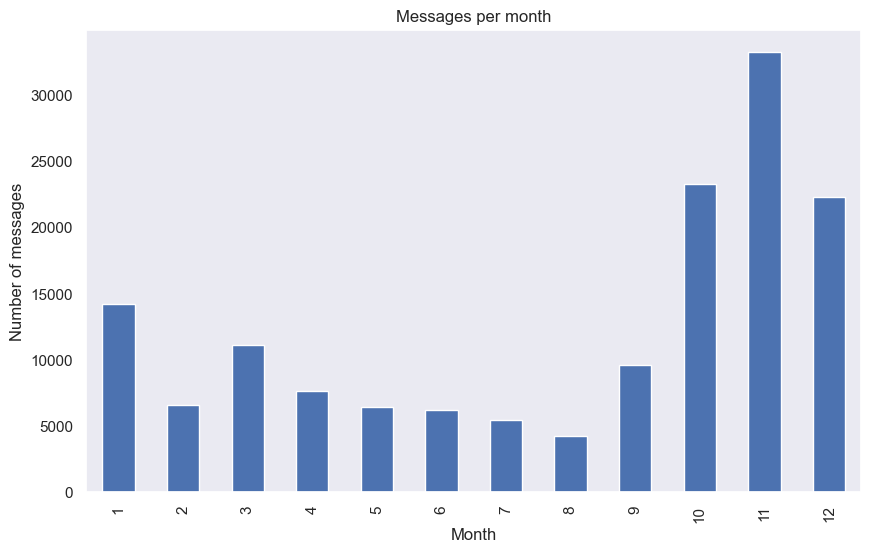

In [198]:
# Generate a distribution plot for the date_source_posted_at field per month
# the plot should have a title
# the plot should have labels for the x and y axis
# the plot should have a legend
# the plot should have a grid

df['date_source_posted_at'].dt.month.value_counts().sort_index().plot(kind='bar')
plt.title('Messages per month')
plt.xlabel('Month')
plt.ylabel('Number of messages')
plt.grid()
plt.show()

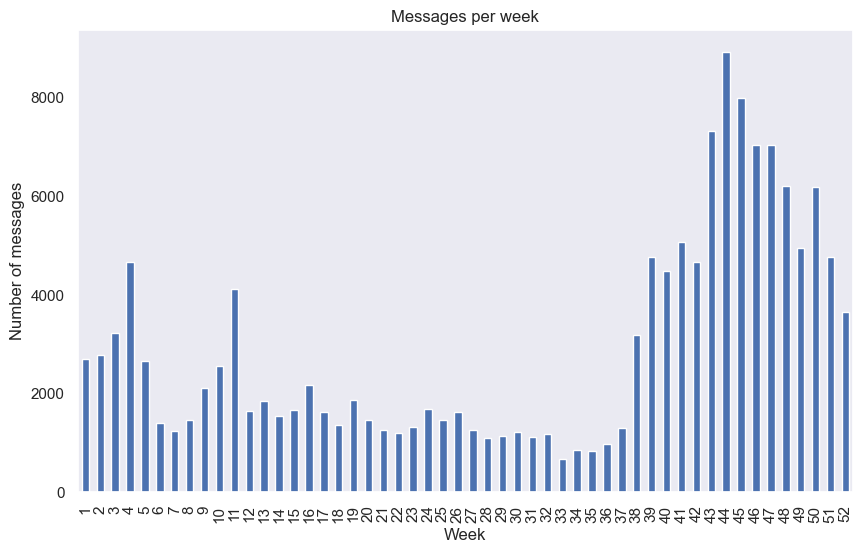

In [200]:
# Generate a distribution plot for the date_source_posted_at field per month
df['date_source_posted_at'].dt.isocalendar().week.value_counts().sort_index().plot(kind='bar')
plt.title('Messages per week')
plt.xlabel('Week')
plt.ylabel('Number of messages')
plt.grid()
plt.show()

In [212]:
# Generate a column with top 10 chat_ids with the highest number of messages and grupo the rest as 'other'
top_chats = df['chat_id'].value_counts().head(10).index
df['chat_id_top'] = df['chat_id'].astype(str)
df.loc[~df['chat_id'].isin(top_chats), 'chat_id_top'] = 'other'

# add a column with the year-month of the message
df['year_month'] = df['date_source_posted_at'].dt.to_period('M')


# Add a column with the year-week of the message
df['year_week'] = df['date_source_posted_at'].dt.to_period('W') # isocalendar().week


/var/folders/c1/5sw0mcxn0s5891c6173ck1sw0000gq/T/ipykernel_12374/2401801314.py:7: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df['year_month'] = df['date_source_posted_at'].dt.to_period('M')
/var/folders/c1/5sw0mcxn0s5891c6173ck1sw0000gq/T/ipykernel_12374/2401801314.py:11: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df['year_week'] = df['date_source_posted_at'].dt.to_period('W') # isocalendar().week


In [223]:
# count the number of messages per year_month and chat_id_top
messages_per_month_chat_id_top = df.groupby(['year_month', 'chat_id_top']).size()
messages_per_month_chat_id_top = messages_per_month_chat_id_top.reset_index()
messages_per_month_chat_id_top.columns = ['year_month', 'chat_id_top', 'count']

# # scacatter plot of chat_id_top per month
# sns.scatterplot(data=df, x='year_month', y= 'chat_id_top')
# plt.title('Messages per month and chat_id_top')
# plt.xlabel('Year-Month')
# plt.ylabel('Chat_id_top')
# plt.grid()
# plt.show()

# plot the number of messages per year_month and chat_id_top
# sns.lineplot(data=messages_per_month_chat_id_top, x='year_month', y='count', hue='chat_id_top')
# plt.title('Messages per month and chat_id_top')
# plt.xlabel('Year-Month')
# plt.ylabel('Number of messages')
# plt.grid()
# plt.show()

messages_per_month_chat_id_top.info()

# plt.title('Messages per month and chat_id_top')
# plt.xlabel('Year-Month')
# plt.ylabel('Number of messages')
# plt.grid()
# plt.show()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82 entries, 0 to 81
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype    
---  ------       --------------  -----    
 0   year_month   82 non-null     period[M]
 1   chat_id_top  82 non-null     object   
 2   count        82 non-null     int64    
dtypes: int64(1), object(1), period[M](1)
memory usage: 2.0+ KB
